In [1]:
#!pwd

In [2]:
#!pip list

In [3]:
import pandas as pd
import numpy as np
from impt import ImpliciTrust
from impt import graph_by_py
from impt import Binarybaseline
import plotly.plotly as py


from surprise import Dataset
from surprise.model_selection import train_test_split
from surprise import NMF
from surprise import SVD
from surprise import SVDpp
from surprise import SVDppimp
from surprise import accuracy

In [4]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import copy as cp

In [5]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_absolute_error

In [6]:
dataset_name ='ml-100k'
# dataset_name ='jester'
# dataset_name ='ml-1m'
# dataset_name ='ml-latest-small'
compare = 5
n_factors = 20
n_epochs = 20
save = False
binary=True
data = Dataset.load_builtin(dataset_name)
trainset, testset = train_test_split(data,random_state=100, test_size=.2)


In [7]:
orginal_binary = True

In [8]:
def get_all_rating_as_df(data):
    daf = DatasetAutoFolds(data)
    fulltrain = daf.build_full_trainset()
    allratings = fulltrain.all_ratings()
    return pd.DataFrame(allratings, columns=['user_id', 'item_id', 'rating', 'timestamp'])
    

In [9]:
def graph_average_plt(data):
    ratingdf = get_all_rating_as_df(data)
    x = ratingdf.user_id
    num_bins = len(ratingdf.user_id.unique())
    n, bins, patches = plt.hist(x, num_bins, facecolor='blue', alpha=0.5)
    plt.show()

In [10]:
#graph_average_plt(data)

In [11]:
b_trainset = cp.deepcopy(trainset)
b_testset= cp.deepcopy(testset)
b_SVD = SVDpp(n_factors= n_factors, random_state=100)
baslineSVD = Binarybaseline(b_SVD)

In [12]:
algo_name = 'SVD_'
algo = SVDpp(n_factors= n_factors, random_state=100)
final_algo = SVDpp(n_factors= n_factors, random_state=100)
print('start')
myalgo = ImpliciTrust(trainset, testset, algo, final_algo, compare=compare, binary=binary, orginal_binary=orginal_binary)
print('myalgo instantiated')

start
myalgo instantiated


In [13]:
myalgo.fit(trainset)
print('fit called')

fitting
converting orginal rating to binary
ir to binary done
ur to binary done
done all_ratings to binary
copying for future use, if needed
changing last col of final_algo.pu
calculating trust for all DataFrame


AttributeError: 'SVDpp' object has no attribute 'biased'

In [14]:
# # print(myalgo.trust_df.groupby(['user_id']).mean().trust.values.tolist())
# # print(myalgo.trust_df.groupby(['user_id']).mean().trust.values.tolist())
# # print(myalgo.trust_df.groupby(['item_id']).mean().trust.values.tolist())
# # user_trust_list = myalgo.trust_df.groupby(['user_id']).mean().trust.values.tolist()

# # print(myalgo.orginal_pu[-1])
# # print(myalgo.orginal_qi[-1])
# listm = myalgo.trust_df.groupby(['user_id']).mean().trust.values.tolist()

# # myalgo.orginal_pu = [np.append(myalgo.orginal_pu, t) for t in user_trust_list]
# # print(len(myalgo.orginal_pu[-1]))
# # for t in listm:
# #     print(t)
# counter = 0
# for t2 in myalgo.orginal_pu:
    
#     templist = []
#     for x in t2:
#         templist.append(x)
#     templist.append(listm[counter])
#     counter =+ 1
#     print(templist)

In [14]:
predictions = myalgo.test(testset)

ValueError: operands could not be broadcast together with shapes (22,) (20,) 

In [16]:
accuracy.rmse(predictions, binary=orginal_binary)
accuracy.mae(predictions, binary=orginal_binary)
# accuracy.fpc(predictions, binary=binary)

RMSE: 0.0222
MAE:  0.0144


0.014357714798895622

In [17]:
print('basline results')
baslineSVD.fit(b_trainset)
b_predictions = baslineSVD.test(testset)
accuracy.rmse(b_predictions,binary=orginal_binary)
accuracy.mae(b_predictions,binary=orginal_binary)
# accuracy.fcp(b_predictions)

basline results
ir to binary done
ur to binary done
done all_ratings to binary
fitting
RMSE: 0.0164
MAE:  0.0085


0.008502461896231482

In [18]:
df = pd.DataFrame(predictions, columns=['user_id', 'item_id', 'ratings_ui', 'estimated_Ratings', 'details'])

In [19]:
def get_Iu(uid):
    try:
        return myalgo.trainset.to_inner_uid(uid)
    except ValueError:  # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    try:
        return myalgo.trainset.to_inner_iid(iid)
    except ValueError:  # item was not part of the trainset
        return 0 

In [20]:
df['Ii'] = df.user_id.apply(get_Iu)
df['Ui'] = df.item_id.apply(get_Ui)
if orginal_binary:
    df['error'] = abs(1 - df.estimated_Ratings)
else:
    df['error'] = abs(df.estimated_Ratings - df.ratings_ui)

In [21]:
# myalgo.t_all_rating[(myalgo.t_all_rating.user_id == 2) & (myalgo.t_all_rating.item_id==2)].trust.item()
df.head()

,user_id,item_id,ratings_ui,estimated_Ratings,details,Ii,Ui,error
0,543,249,2.0,1.048342,{'was_impossible': False},270,186,0.048342
1,402,12,4.0,1.019845,{'was_impossible': False},837,375,0.019845
2,49,52,2.0,1.005830,{'was_impossible': False},232,77,0.005830
3,425,529,4.0,1.030192,{'was_impossible': False},114,1020,0.030192
4,321,30,4.0,1.019496,{'was_impossible': False},525,813,0.019496


In [22]:
def graph_trust_pairs(ratingdf, size, save=False, orderbycol='trust', error_scale=100000, trust_scale=10000):
    t = np.arange(0.0, size, 1)

    fig, ax = plt.subplots()
    fig.set_figheight(5)
    fig.set_figwidth(15)

    ax.plot(t,ratingdf.head(size).sort_values(by=orderbycol).error *error_scale)

    ax.plot(t,ratingdf.head(size).sort_values(by=orderbycol).trust *trust_scale)
    

    ax.set(xlabel='rating instances', ylabel='Trust',
           title='Trust per pair')
    ax.grid()

    if save:
        fig.savefig("trustperpair.png")
    plt.show()

In [25]:
t = []
est_t = []
i_count_list = []
u_count_list = []
pairtrust_list = []
ir_trust_list = []
for index, row in df.iterrows():
    val = myalgo.single_user_trust(row['user_id'], row['item_id'])
#     esttr = myalgo.single_user_item_est_trust(row['user_id'], row['item_id'])
#     ucount, icount, pairtrust = myalgo.any_pair_trust(row['user_id'], row['item_id'], row['ratings_ui'])
#     ir_trust_list.append(myalgo.single_item_trust_ir_ur(row['user_id'], row['item_id']))
    t.append(val)
#     i_count_list.append(icount)
#     u_count_list.append(ucount)
#     pairtrust_list.append(pairtrust)
#     est_t.append(esttr)
df['trust'] = t
# df['est_trust'] = est_t
# df['u_count'] = u_count_list
# df['i_count'] = i_count_list
# df['pairtrust'] = pairtrust_list
# df['ir_trust'] = ir_trust_list
df.head()

,user_id,item_id,ratings_ui,estimated_Ratings,details,Ii,Ui,error,trust
0,543,249,2.0,1.048342,{'was_impossible': False},270,186,0.048342,0.0
1,402,12,4.0,1.019845,{'was_impossible': False},837,375,0.019845,0.0
2,49,52,2.0,1.005830,{'was_impossible': False},232,77,0.005830,0.0
3,425,529,4.0,1.030192,{'was_impossible': False},114,1020,0.030192,0.0
4,321,30,4.0,1.019496,{'was_impossible': False},525,813,0.019496,0.0


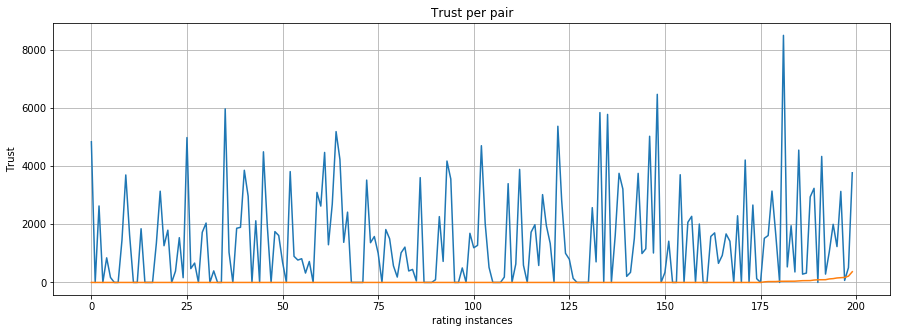

In [26]:
graph_trust_pairs(df, 200)

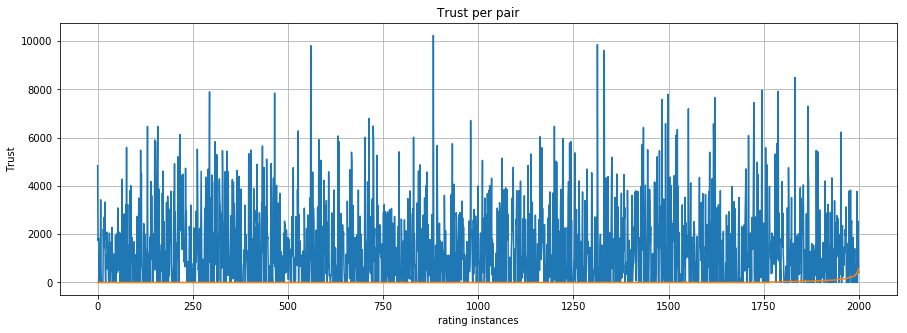

In [27]:
graph_trust_pairs(df, 2000)

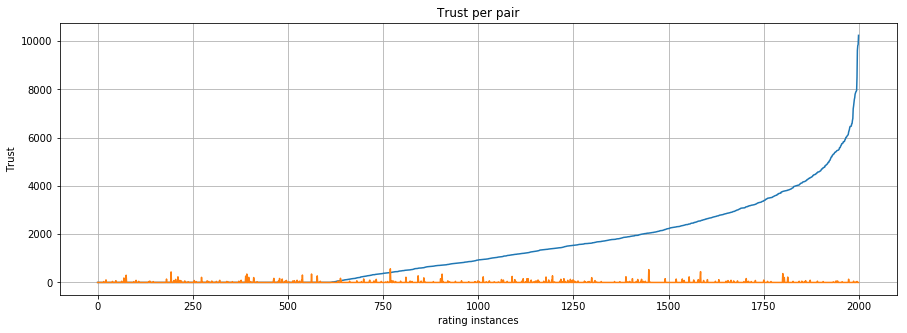

In [28]:
graph_trust_pairs(df, 2000, orderbycol='error')

In [29]:
trustdf = df.loc[df.trust > 0].sort_values(by='error')
len(trustdf)

2126

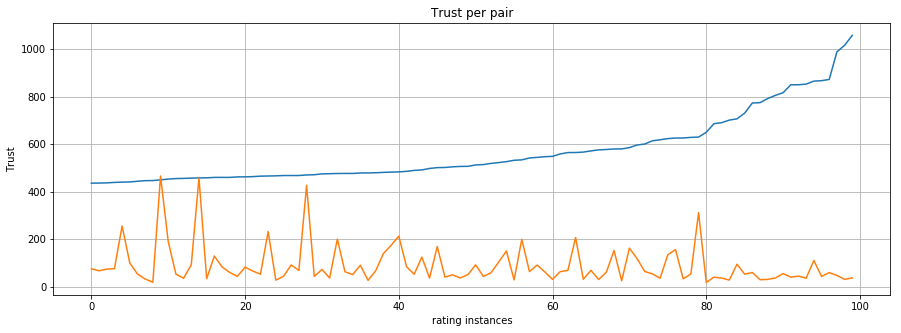

In [30]:
graph_trust_pairs(trustdf[-100:], 100, orderbycol='error', error_scale=10000, trust_scale=10000)

In [31]:
trustdf['error'].corr(trustdf['trust'])

-0.01848838699556861

In [26]:
df['trust'].corr(df['est_trust'])

-0.0009580898019203228

In [27]:
df['error'].corr(df['est_trust'])

0.006214561539801752

In [32]:
df['error'].corr(df['Ii'])

0.06343329491383051

In [29]:
df['est_trust'].corr(df['Ii'])

0.0038982759894792647

In [33]:
df['trust'].corr(df['Ii'])

-0.07053939615504308

In [31]:
df['trust'].corr(df['Ui'])

-0.06704637696125196

In [32]:
df['est_trust'].corr(df['Ui'])

-0.0005014394476034777

In [34]:
df['error'].corr(df['Ui'])

0.048580708995262165

In [35]:
df['error'].corr(df['trust'])

-0.02112358252721363